# Titanic -- Preliminary Exploration

**Author**:  _Vasilis Oikonomou_


**Language**:  _Python 3_


**Date**:  _June 24th 2016_

**Version**:  1

## Table of Contents

* **[Understanding the dataset](#intro)**
 * [What do the variables mean?](#vars)
 * _[Variable Importance(first taste)](#var_imp)
* **[Feature Engineering](#feats)**
 * [Title](#title)
 * [Family Size](#fsize)
 * [Deck](#deck)
 * [Ticket prefix](#ticket)
* **[Data Curation](#cur)**
 * [Fare](#fare)
 * [Age](#age)
* **[Visualizations!](#viz)**
* **[Model Formulation](#model)**
* **[Submission](#submission)**

<a name="intro"></a>

## Understanding the dataset
**Welcome to my exploration of the _Titanic_ dataset on Kaggle. This document contains a first exploration of the data set along with a simple first submission. I am a beginner in ML so definitely feel free to comment your suggestions below so that I can include them in future versions!**

***Hope you enjoy this!,***
   
   
   **V**

In [1]:
#import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from biokit.viz import corrplot
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn import linear_model
from sklearn import ensemble
from sklearn import svm
from sklearn import tree
from sklearn import neighbors 
from sklearn import naive_bayes
from sklearn import metrics
from sklearn.feature_selection import SelectKBest
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from time import clock
from statsmodels.graphics.mosaicplot import mosaic
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
#import our data
train = pd.read_csv("data/train.csv", )
test = pd.read_csv("data/test.csv")

In [3]:
# Columns Age, Cabin and Embarked look like they have some missing data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


<a name="vars"></a>

### What do the variables mean?
Our dataset intially consists of 11 variables. Note that some columns have missing values. We will deal with them in later sections. For now let's make sure we understand what each variable means.

| **Variable name** | **Explanation**    
| :------------- |:-------------
| **Survived**| `1(survived) 0(died)`
| **Pclass**      | `Passenger's class (1st, 2nd or 3rd)`     
| **Name**| `Name of passenger ` 
| **Sex**| `Passenger's gender`
| **Age**| `Age of passenger`
| **SibSp**| `Number of siblings/spouses aboard`
| **Parch**| `Number of parents/children aboard`
| **Ticket**| `Passenger's ticket number`
| **Fare**| `Amount paid for ticket`
| **Cabin**| `Passenger's Cabin number`
| **Embarked**| `Port of embarkation`



In [4]:
#Let's express the categorical variables we have, namely Sex. This will be usefull for the following section
tempo = pd.get_dummies(train[['Sex']])
train['male'] = tempo['Sex_male']
train['female'] = tempo['Sex_female']

<a name="var_imp"></a>

### Variable Importance (first taste)

Computing correlation


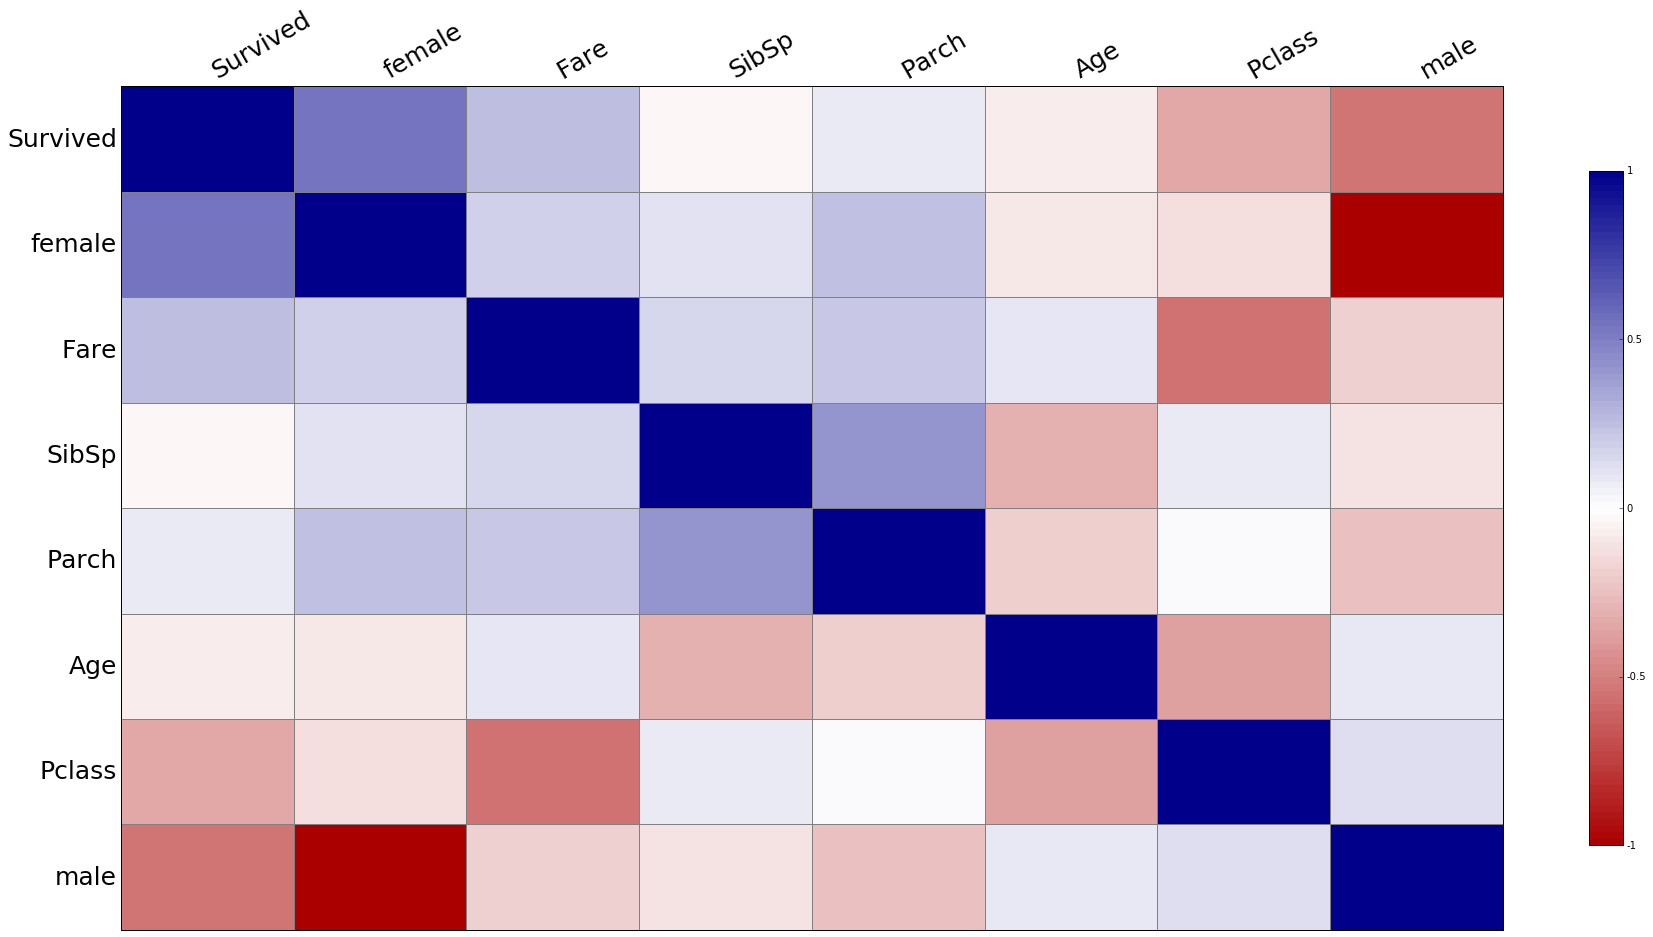

In [5]:
# Now let's plot a correlation plot with what we are given
fig = plt.figure()
fig.set_figheight(25)
fig.set_figwidth(50)
ax1 = fig.add_subplot(221)
c = corrplot.Corrplot(train.drop(['PassengerId', 'Cabin'], axis=1))
c.plot(fig=fig, ax=ax1, method='color', fontsize=25)
# By just getting a taste of which variables are important to us, we see that both gender(male, female) and Pclass 
# seem to be quite important (Generally we are looking for dark colored squares). Feel free to change the 'method' 
# variable from color to text and add colorbar=False to the parameters passed in the plot to see the actual 
# correlation.

<a name="feats"></a>

## Feature Engineering
Here we will experiment with some new features that we can use. This section is very important since you can (and should) try  all the ideas you have on new features that will improve your learning algorithm.

<a name="title"></a>

### Title
Extract the Title of each passenger using regular expressions. Regular expressions (also refered to as regex) is a sequence of characters that define and search for a pattern in a string.  Also note that from now on I will be using a combined version of our data (both train and test data) so that I won't have to rewrite code to create the test set features.

In [6]:
data = train.append(test)
data.drop(["female", "male"], axis=1, inplace=True)

In [7]:
# Here is a pivot table with the Titles and the gender. Note that there should be a 
# high correlation between the two variables but that is ok for now.
titles = []
for name in data.Name:
    titles.append(re.search(r'[A-Z][a-z]+\.', name).group())
data['Title'] = titles
pd.crosstab(data['Sex'], data['Title'],rownames=['Gender'], colnames=['Title'])

Title,Capt.,Col.,Countess.,Don.,Dona.,Dr.,Jonkheer.,Lady.,Major.,Master.,Miss.,Mlle.,Mme.,Mr.,Mrs.,Ms.,Rev.,Sir.
Gender,,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0
male,1,4,0,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1


In [8]:
# There are some titles with very few counts. We could group those into a collection of rare titles
rare = ["Capt.", "Col.", "Countess.", "Don.", "Dona.", "Jonkheer.", "Dr.", "Dr.", "Major.", "Rev.", "Sir.", "Lady."]
for i in range(len(titles)):
    if titles[i] in rare:
        titles[i]='rare'
data['Title']=titles

In [9]:
# Also reassign mlle, ms, and mme, lady accordingly
data = data.replace(to_replace='Mlle.', value='Miss.')
data = data.replace(to_replace='Ms.', value='Miss.')
data = data.replace(to_replace='Mme.', value='Mrs.')

In [10]:
#Our new pivot table looks like this
pd.crosstab(data['Sex'], data['Title'],rownames=['Gender'], colnames=['Title'])

Title,Master.,Miss.,Mr.,Mrs.,rare
Gender,,,,,
female,0,264,0,198,4
male,61,0,757,0,25


In [11]:
# Survival in this case does not seem to depend to much on the title. perhaps we should revisit that feature to make 
# it more informative.
pd.crosstab(data['Survived'], data['Title'],rownames=['Survived'], colnames=['Title'])

Title,Master.,Miss.,Mr.,Mrs.,rare
Survived,,,,,
0.0,17,55,436,26,15
1.0,23,130,81,100,8


<a name="fsize"></a>

### Family Size
Now we will examine family sizes. Some intuition behind this is that families with children may have escaped the disaster if they were given priority when abandoning the sinking ship.

In [12]:
# family size for each passenger
data['Fsize'] = np.array(data['Parch'])+np.array(data['SibSp']) + 1

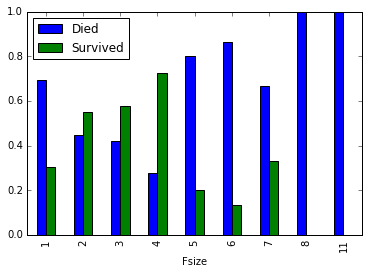

In [13]:
# Now let's explore the relation between family size and survival rate
survived = data[data['Survived']==1]
died = data[data['Survived']==0]
died['Died'] = 1
died.drop("Survived", axis=1, inplace=True)
survived = survived.groupby('Fsize')[['Survived']].sum()
died = died.groupby('Fsize')[['Died']].sum()
result = pd.concat([died, survived], axis=1)
result = result.fillna(0)
# convert to proportions
total = np.array(result['Died'])+np.array(result['Survived'])
result['Died'] = np.array(result["Died"])/total
result['Survived'] = np.array(result["Survived"])/total
result.plot(kind='bar')

In [14]:
# clearly we see that the only types of families that survived are mainly those of 2, 3 and 4 people while others seem
# to have perished
#Hence, we can encode the family size into 3 categorical variables, small, medium and large based on their size
def encode_fsize(x):
    if x==1:
        return 'small'
    elif x<5:
        return 'medium'
    else:
        return 'large'

In [15]:
data['Fsize']=data['Fsize'].apply(encode_fsize)

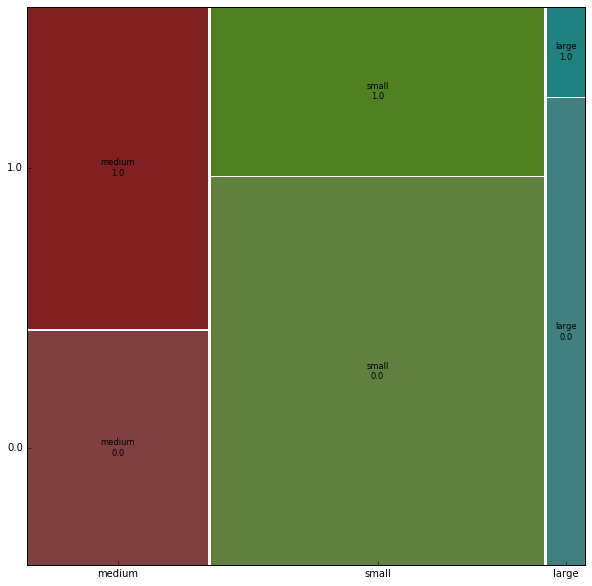

In [16]:
f, a = mosaic(data, ['Fsize', 'Survived'])
f.set_figheight(10)
f.set_figwidth(10)

In [17]:
data.drop(['SibSp','Parch'], axis=1, inplace=True)

<a name="deck"></a>

### Deck

In [18]:
# In this part we will utilize the cabin variable that we have to see what was the deck of each passenger
# Z if value is nan
data['Deck'] = data['Cabin'].apply(lambda x: x[0] if type(x)==type('str') else 'Z')
data.drop('Cabin', axis=1, inplace=True)

<a name="ticket"></a>

### Ticket prefix

In [19]:
# For this feature we will attempt to examine the significance of the ticket prefix, eg A/5, PC etc
data['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [20]:
data['TicketPrefix'] = data["Ticket"].apply(lambda i: i.split(" ")[0] if len(i.split(" "))>=2 else '0')

In [21]:
data['TicketPrefix'] = data['TicketPrefix'].apply(lambda x: re.sub(r'[/\.]', "", x))

<a name="cur"></a>

## Data Curation

Now that we have made some new features, it is time to take a look at our dataset and see how we can deal with missing values and/or other anomalies that we come across. Note that we know from the beginning of the exploration that the colmns Age, Embarked, Cabin and Fare have some missing values

<a name="fare"></a>

### Fare

In [22]:
# What is interesting here is that the minimum Fare paid in this case is 0. Could those cases be babies who just did 
# not pay to get on board?
data.describe()

,Age,Fare,PassengerId,Pclass,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,655.000000,2.294882,0.383838
std,14.413493,51.758668,378.020061,0.837836,0.486592
min,0.170000,0.000000,1.000000,1.000000,0.000000
25%,21.000000,7.895800,328.000000,2.000000,0.000000
50%,28.000000,14.454200,655.000000,3.000000,0.000000
75%,39.000000,31.275000,982.000000,3.000000,1.000000
max,80.000000,512.329200,1309.000000,3.000000,1.000000


In [23]:
#Clearly these people are not babies, and the almost 0 fare is probably due to some error in our data
# Let's replace those people's fare(including those with nan values) with the mean fare of their class 
# and port of embarkation.
free_loaders = data[data['Fare']<5]
free_loaders[['Age', 'Fare', 'Pclass']][:10]

,Age,Fare,Pclass
179,36.0,0.0000,3
263,40.0,0.0000,1
271,25.0,0.0000,3
277,NaN,0.0000,2
302,19.0,0.0000,3
378,20.0,4.0125,3
413,NaN,0.0000,2
466,NaN,0.0000,2
481,NaN,0.0000,2
597,49.0,0.0000,3


In [24]:
class_port_means = pd.crosstab(data['Pclass'], data['Embarked'], values = data['Fare'], aggfunc='mean',
                               rownames=['Pclass'], colnames=['Title'])
class_port_means

Title,C,Q,S
Pclass,,,
1,106.845330,90.000000,72.148094
2,23.300593,11.735114,21.206921
3,11.021624,10.390820,14.435422


In [25]:
new_fares = []
for i in range(len(data)):
    if np.array(data['Fare'])[i]<5 or np.isnan(np.array(data['Fare'])[i]):
        new_fares.append(class_port_means[np.array(data.Embarked)[i]][np.array(data.Pclass)[i]])
    else:
        new_fares.append(np.array(data['Fare'])[i])
data['Fare'] = new_fares

<a name="age"></a>

### Age 
For the time being we will just replace the missing values in our table with the mean of the entire data set. We will revisit section perhaps later.

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 13 columns):
Age             1046 non-null float64
Embarked        1307 non-null object
Fare            1309 non-null float64
Name            1309 non-null object
PassengerId     1309 non-null int64
Pclass          1309 non-null int64
Sex             1309 non-null object
Survived        891 non-null float64
Ticket          1309 non-null object
Title           1309 non-null object
Fsize           1309 non-null object
Deck            1309 non-null object
TicketPrefix    1309 non-null object
dtypes: float64(3), int64(2), object(8)
memory usage: 143.2+ KB


In [844]:
mean_age = np.mean(data['Age'])
data = data.fillna(mean_age)

In [845]:
data['Embarked'] = data.replace(to_replace=29.881137667304014, value='S')['Embarked']

<a name="viz"></a>

## Visualizations!
This section will be about giving you some more interesting visualizations I have come across. 

In [846]:
# As a first task, let's examine the survival rates for gender, port of embarkation and passenger class
# For this task we will only keep the training set part of our data
train = data[np.logical_or(data['Survived']==1, data['Survived']==0)]
vars = ['Sex', 'Pclass', 'Embarked']

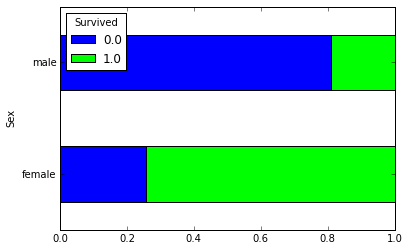

In [847]:
# Survival based on gender
table = train.groupby(['Sex', 'Survived']).size()
table = table.unstack() #splits the data into 2 columns, 0, 1, each indexed by the
                                    #other variable
normedtable = table.div(table.sum(1), axis=0) #divides the counts by the totals
normedtable.plot(kind='barh', stacked=True, colormap='brg')

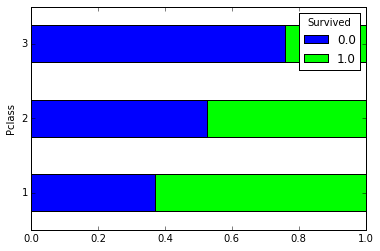

In [848]:
#Survival based on passenger class
# Survival based on gender
table = train.groupby(['Pclass', 'Survived']).size()
table = table.unstack() #splits the data into 2 columns, 0, 1, each indexed by the
                                    #other variable
normedtable = table.div(table.sum(1), axis=0) #divides the counts by the totals
normedtable.plot(kind='barh', stacked=True, colormap='brg')

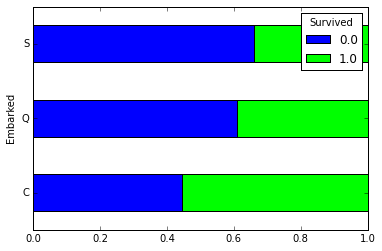

In [849]:
#Survival based on the port of embarkation
# Survival based on gender
table = train.groupby(['Embarked', 'Survived']).size()
table = table.unstack() #splits the data into 2 columns, 0, 1, each indexed by the
                                    #other variable
normedtable = table.div(table.sum(1), axis=0) #divides the counts by the totals
normedtable.plot(kind='barh', stacked=True, colormap='brg')

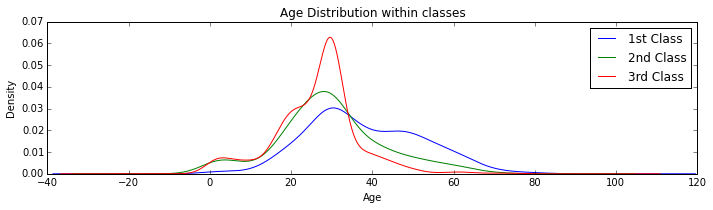

In [850]:
# specifies the parameters of our graphs
fig = plt.figure(figsize=(18,6), dpi=1600) 
alpha=alpha_scatterplot = 0.2 
alpha_bar_chart = 0.55

plt.subplot2grid((2,3),(1,0), colspan=2)
# plots a kernel density estimate of the subset of the 1st class passangers's age
data.Age[data.Pclass == 1].plot(kind='kde')    
data.Age[data.Pclass == 2].plot(kind='kde')
data.Age[data.Pclass == 3].plot(kind='kde')
 # plots an axis lable
plt.xlabel("Age")    
plt.title("Age Distribution within classes")
# sets our legend for our graph.
plt.legend(('1st Class', '2nd Class','3rd Class'),loc='best')

### Did children have a higher chance of survival? 
If we think about it, it makes sense that children would have a better chance of surviving the shipwreck since they were probably given priority when leaving the ship. Let's test that by doing some permutation tests! In this section we will define children as passengers younger than 18 yrs old.

In [851]:
# For this exercise, we will use our train data only 
train = data[:len(train)]
#Overall survival rate on the Titanic
prop_died_overall, prop_survived_overall = train['Survived'].value_counts(normalize=True)
# Children's survival rate
children = train[train['Age']<=18]
prop_children_died, prop_children_survived = children['Survived'].value_counts(normalize=True)
print("Overall in the Titanic: {0:.2f}% died and {1:.2f}% survived.".format(prop_died_overall*100, 
                                                                    prop_survived_overall*100))
print("Of the children in the Titanic: {0:.2f}% died and {1:.2f}% survived.".format(prop_children_died*100, 
                                                                    prop_children_survived*100))

Overall in the Titanic: 61.62% died and 38.38% survived.
Of the children in the Titanic: 50.36% died and 49.64% survived.


We see that the numbers are clearly different, however how statistically significant are they. We will examine this under the following null hypothesis:

**Null hypothesis**: __The chance that a child survived the Titanic shipwreck is the same as the one for everu other passenger on the ship and any difference is due to chance. In other words, it is like flipping a coin where the chance of getting tails(surviving) is around 38% just like for everyone else on the ship.__

For our hypothesis testing, we will use the survival rate as our test statistic.

**Action Plan:** We will perform a permutation test, meaning that since it does not matter whether teh passenger was a child or not we can go about shuffling the survived column of our data frame, then isolating the children and measuring their survival rate. If we do this 10000 times we will get an empirical distribution of their survival rate assuming that our null hypothesis is true. After we will calculate the p-value of our observed survival rate and if that is below a certain threshold (usually 0.05) then we will say that there is strong evidence against the null hypothesis.

In [852]:
observed_statistic = prop_children_survived * 100
tmp = train.copy()
dist_survived = []
for _ in range(10000):
    shuffled_col = np.array(train['Survived'].sample(frac=1, replace=False))
    tmp['Survived'] = shuffled_col
    child = tmp[tmp['Age']<=18]
    prop_died, prop_survived = child['Survived'].value_counts(normalize=True)
    dist_survived.append(prop_survived*100)

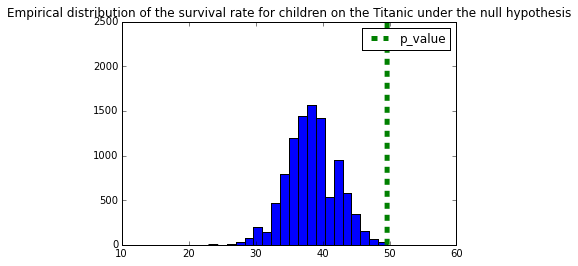

In [853]:
plt.hist(dist_survived, bins=20)
plt.plot([observed_statistic]*2500, np.arange(0, 2500), '--', linewidth=5, label='p_value')
plt.xlim(10, 60)
plt.title("Empirical distribution of the survival rate for children on the Titanic under the null hypothesis")
plt.legend()

In [854]:
#measuring the p_value
p_value = np.count_nonzero(dist_survived>=observed_statistic)/len(dist_survived)
print("The p-value observed in this case is: {}".format(p_value))

The p-value observed in this case is: 0.0018


**Conclusion:** The p-value that we observed in our permutation test is clearly highly statistically significant which is evidence against the null hypothesis. Hence, unless we see a sample which is completely unrepresentative of the actual population, we can conclude that the null hypothesis probably does not stand.

<a name="model"></a>

## Model Formulation

### Data Normalization
To be able to run our models, we need to make sure that all our data are on the correct scale, so that our learning algorithms work properly. In this case, I will convert all columns needed (namely those that are not binary) in standard units (su = (value-mean)/std) so that my new data has a 0 mean and a 1 variance.

In [855]:
#sklearn preprocessing
# Note that the values derived are not exactly 0 or 1 but are awefully close to those values.
cols_to_normalize = ["Fare", "Age"]
data['Fare'] = preprocessing.scale(data['Fare'])
data['Age'] = preprocessing.scale(data['Age'])
print("Mean Age is ", np.mean(data['Age']))
print("Mean Fare is ", np.mean(data['Fare']))
print("SD Age is ", np.std(data['Age']))
print("SD Fare is ", np.std(data['Fare']))

Mean Age is  1.538536720145175e-16
Mean Fare is  -9.79608551139844e-18
SD Age is  1.0000000000000004
SD Fare is  0.9999999999999997


### Write DataFrames 
Writes dataframes to csv for model training

In [856]:
data.to_csv('processed_data.csv', index=False)

### Data formatting
Put the data in the correct format to train our classifiers.

In [857]:
# First, we need to put categorical data into dummy variables. Luckily pandas has a very handy function for that.
to_be_replaced = ['Sex', "Embarked", 'Deck', 'TicketPrefix', 'Fsize', 'Title']
added_cols = pd.get_dummies(data[to_be_replaced])
added_cols['PassengerId'] = data['PassengerId']
data = pd.merge(data, added_cols, on='PassengerId')
tmp = pd.get_dummies(data['Pclass'])
tmp.columns=["Class 1", "Class 2", "Class 3"]
tmp['PassengerId'] = data['PassengerId']

In [858]:
data.drop(to_be_replaced, axis=1, inplace=True)
data.drop("Pclass", axis=1, inplace=True)
data = pd.merge(data, tmp, on='PassengerId')

### Predictions

In [859]:
train = data[:len(train)]
test = data[len(train):]

In [860]:
X=train.drop(['Ticket', 'Name', 'PassengerId', 'Survived'], axis=1).as_matrix()
Y= np.array(train['Survived'])

In [861]:
#At this point we will define a utility function which will abstract away some of the code for us
def report(clf, X, Y):
    start=clock()
    predicted = cross_validation.cross_val_predict(clf, X, Y, cv=10)
    end = clock()
    print("Accuracy: ", metrics.accuracy_score(Y, predicted))
    print("Recall: ", metrics.recall_score(Y, predicted))
    print("Precision: ", metrics.precision_score(Y, predicted))
    print("F1: ", metrics.f1_score(Y, predicted))
    print("Time elapsed: ", end-start)

In [862]:
# Now that everything is set, use cross validation to test different learning algorithms and see how they perform
print('---------------------------------')
print('Logistic Regression')
clf = linear_model.LogisticRegression()
report(clf, X, Y)
print('---------------------------------')
print('SVM')
clf = svm.SVC()
report(clf, X, Y)
print('---------------------------------')
print('Random Forest')
clf = ensemble.RandomForestClassifier()
report(clf, X, Y)
print('---------------------------------')
print('Naive Bayes')
clf = naive_bayes.BernoulliNB()
report(clf, X, Y)
print('---------------------------------')
print('Decision Tree Classifier')
clf = tree.DecisionTreeClassifier()
report(clf, X, Y)

---------------------------------
Logistic Regression
Accuracy:  0.835016835017
Recall:  0.760233918129
Precision:  0.8
F1:  0.779610194903
Time elapsed:  0.07735900000000129
---------------------------------
SVM
Accuracy:  0.832772166105
Recall:  0.733918128655
Precision:  0.812297734628
F1:  0.771121351767
Time elapsed:  0.5946350000000393
---------------------------------
Random Forest
Accuracy:  0.811447811448
Recall:  0.707602339181
Precision:  0.78064516129
F1:  0.742331288344
Time elapsed:  0.2044899999999643
---------------------------------
Naive Bayes
Accuracy:  0.784511784512
Recall:  0.771929824561
Precision:  0.698412698413
F1:  0.733333333333
Time elapsed:  0.06425999999999021
---------------------------------
Decision Tree Classifier
Accuracy:  0.7822671156
Recall:  0.713450292398
Precision:  0.717647058824
F1:  0.715542521994
Time elapsed:  0.07589300000000776


<a name="submission"></a>

## Submission

In [864]:
# Based on my training data, the best-performing algorithm is Logistic Regression with SVM following closely
# Based on the leaderboard, LR gives a 77.5 on the test set
X_test = test.drop(['Ticket', 'Name', 'PassengerId', 'Survived'], axis=1).as_matrix()
clf = ensemble.RandomForestClassifier(random_state = 10, warm_start = True, 
                                  n_estimators = 26,
                                  max_depth = 6, 
                                  max_features = 'sqrt')
clf.fit(X, Y)
predictions = clf.predict(X_test)

In [865]:
def make_submission_file(filename, predictions):
    results = pd.DataFrame()
    results['Survived'] = [int(i) for i in predictions]
    results['PassengerId'] = np.array(test.axes[0])+1
    results.to_csv(filename,index=False)

In [866]:
#make submission
filename = "version 0.5.csv"
make_submission_file(filename, predictions)